## РИА Новости

# Часть 1

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

In [3]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/data/df_final.p', compression='gzip')
df.drop(columns='id', inplace=True)
df = df.reset_index(drop=True)

print(f'Размер датасета: {df.shape}')
df.head()

FileNotFoundError: ignored

In [ ]:
# Размер каждой категории
df.topic.value_counts()

Видим, что в целом наши категории вполне сбалансированы. Это не удивительно, поскольку мы настроили парсер именно так, чтобы выгрузить по каждой тематике приблизительно равное количество статей.

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12,4))
sns.countplot(y=df["topic"], palette='tab10', ax=ax)
plt.title('Number of news by topics');

Сама по себе дата как строка не является признаком, однако ее компоненты могут играть важную роль в работе модели. Поэтому мы преобразуем строковую дату в формат datetime и добавим к нашим признакам год, месяц и день недели.

In [ ]:
df['datetime'] = pd.to_datetime(df.datetime)
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.strftime("%B")
df['weekday'] = df['datetime'].dt.strftime('%A')

Какие выводы можно сделать по графикам ниже:
- Все новости относятся к 2021 году
- Больше всего новостей приходится на конец года (Ноябрь, Декабрь - лидер)
- Меньше всего новостей в выходные и больше всего в начале недели

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(16, 6), dpi=100)
for ind, col in enumerate(['year', 'month', 'weekday']):
    sns.countplot(x=df[col], palette='tab10', ax=axs[ind], order=df[col].value_counts(ascending=True).index)
axs[0].set_title('Count news by datetime');

Посмотрим на распределение числа просмотров по каждой из тематик. Видим, что имеются очень тяжелые хвосты в каждой из тем, то есть в датасете присутствуют статьи, сильно выделяющиеся по своей популярности. Однако, сразу нужно отметить, что количество просмотров также зависит от возраста статьи, поэтому зависимость популярности от количества просмотров имеет не линейную, а более сложную зависимость.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
sns.boxplot(x="topic", y="views", data=df, ax=ax)
plt.title('Boxplot of views by topics');

Рассмотрим в целом на распределение количества просмотров по всем данным.

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
sns.despine(fig)

sns.histplot(
    df,
    x="views",
    edgecolor=".3",
    linewidth=.5,
);
axs.set_title('Views distribution over topic');

Во-первых, как уже отмечалось, у распределения количества просмотров есть далекие выбросы. Более того, форма распределения очень похожа на логнормальное распределение. Поэтому добавим еще один признак - логарифм количества просмотров, сдвинутого на единицу, поскольку количество просмотров может принимать значение ноль.

На графике ниже по оси абсцисс отложен log1p количества просмотров, а по оси ординат - количество статей разных тематик, имеющих такое количество просмотров. Видно, что теперь распределение имеет форму, близкую к нормальному распределению, хоть оно немного скошено вправо и имеет отрицательный коэффициент асимметрии (skewness).

In [ ]:
df['log_views'] = np.log1p(df['views'])

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
sns.despine(fig)

sns.histplot(
    df,
    x="log_views",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
);
axs.set_title('Views distribution over topic');

Посчитаем длину заголовков и основного текста.

In [ ]:
df['len_title'] = df['title'].str.len()
df['len_subtitle'] = df['subtitle'].str.len()
df['len_content'] = df['content'].str.len()

Посмотрим, как они выглядят в разрезе каждой категории.

In [ ]:
for col in ['len_title', 'len_subtitle', 'len_content']:
    fig, ax = plt.subplots(1, 1, figsize=(12, 5), dpi=100)
    sns.boxplot(x="topic", y=col, data=df, ax=ax)
    plt.title(f'Boxplot of {col} by topics');

Что можно заметить:
- В среднем длина заголовка по всем категориям около 65 символов
- Второй загловок по некоторым статьям недоступен - поэтому в будущем его следует отбросить
- Длина текста имеет тяжелые хвосты, особенно по категориям: 'world', 'economy topic', 'society'

Посмотрим, какие ключевые слова чаще всего встречаются в статьях каждой тематики. Одной из гипотез является то, что статьи разных, но при этом близких тематик с одинаковыми ключевыми словами могут вносить негативный вклад в работу модели.

In [ ]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык'])

In [ ]:
%%time
for topic in df.topic.unique():
    words = df[df.topic == topic].title.str.split(' ').explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {topic} topic", fontsize=30)
    ax.imshow(wc, alpha=0.98)

    break


На данный момент мы выкачиваем статьи в обратном хронологическом порядке. Это значит, что в выборку попадают, как старые, так и совершенно новые статьи. Это сильно влияет на один из признаков - количество просмотров. Поэтому для корректной работы модели необходимо будет каким-то образом отнормировать этот признак. Для этого сначала посмотрим распределение возраста статей, а затем распределение отношения количества просмотров к возрасту статьи. Это будет не столь корректной оценкой, потому что количество просмотров со временем растет нелинейно. Скорее всего, эта зависимость имеет экспоненциальный характер с некоторой линией насыщения - асимптотой. Но для нулевого приближения попробуем сначала рассмотреть самый простой вариант.

In [ ]:
df['lifetime'] = df['datetime'].apply(lambda x: (datetime.datetime.now() - x).total_seconds())
df['lifetime'] = df['lifetime'].apply(lambda x: divmod(x, 60)[0]) # lifetime in minutes

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
sns.despine(fig)

sns.histplot(
    df,
    x="lifetime",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Lifetime distribution over topic, minutes');

Как и ожидалось, в датасете присутствуют как старые статьи, так и новые. И само распределение имеет довольно неоднозначную форму.

In [ ]:
df['views_by_minutes'] = (df['views'] + 1) / df['lifetime']
df['log_views_by_minutes'] = np.log1p(df['views_by_minutes'])

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
sns.despine(fig)

sns.histplot(
    df,
    x="log_views_by_minutes",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Lifetime distribution over topic, minutes');

А вот новый признак - количество просмотров в минуту, или средняя скорость роста количества просмотров, - имеет уже распределение, близкое к логнормальному, и с таким признаком уже можно как-то работать.

# Часть 2

In [ ]:
!pip install natasha

In [ ]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

import mlxtend
from mlxtend.evaluate import paired_ttest_kfold_cv

from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
RND_STATE = 73

# Предобработка текста
Чтобы получить более точное и компактное представление текстов, обычно делают нормализацию текста, которая включает в себя следующие этапы:
- lowering
- tokenize
- lemmatize
- remove symbols
- remove stop-words

Для нас совершенно не важен регистр текста, его род и падеж, а также различные символы, которые и вовсе текстом не являются.

Таким образом, мы ожидаем, что после предобработки текста качество модели должно возрасти.

Существуют разные библиотеки для обработки текста, мы будем использовать Наташу, потому что она включяет в себя все необходимые нам элементы предобработки (токенизация и лемматизация), а также [демонстрирует сравнительно хорошее качество](https://github.com/natasha/naeval) при работе с русским языком.

In [ ]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

Напишем функцию, которая будет осуществлять всю указанную выше предобработку текста.

In [ ]:
def text_prep(text) -> str:
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    lemmas = [_.lemma for _ in doc.tokens]
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

Обработаем доступные нам текстовые поля.

In [ ]:
%%time
df['title_clean'] = df.title.apply(text_prep)
df['subtitle_clean'] = df.subtitle.apply(text_prep)
df['content_clean'] = df.content.apply(text_prep)

NameError: ignored

Посмотрим, насколько разумно работает наша предобработка, оценив качество преобразования текстовых данных.

In [ ]:
# Заголовок
df.sample(1)[['title', 'title_clean']].values

array([['Россиянам назвали способы экономии на покупке авто',
        'россиянин назвать способ экономия покупка авто']], dtype=object)

In [ ]:
# Подзаголовок
df.sample(1)[['subtitle', 'subtitle_clean']].values

array([['Туристический автобус, в котором находились более 30 человек, попал в ДТП в Карелии',
        'туристический автобус находиться человек попасть дтп карелия']],
      dtype=object)

In [ ]:
# Содержание
df.sample(1)[['content', 'content_clean']].values

array([['МОСКВА, 24 окт — РИА Новости. В условиях непредсказуемости финансовых рынков следует применять диверсифицированный подход к сохранению сбережений, но стоит обратить внимание на инвестиционные инструменты с привязкой к так называемым "принципам ESG", заявил РИА Новости глава Росбанка Илья Поляков."Непредсказуемые движения финансовых рынков в последние кварталы, на мой взгляд, подтвердили необходимость диверсифицированного подхода к сохранению и приумножению сбережений. При этом для занятия тех или иных позиций выгодно использовать переломные моменты трендов", — считает он.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nПоляков напомнил, что в этом году Центробанк уже несколько раз повышел ключевую ставку, и некоторые эксперты полагают, что ее пик уже не за горами.\n\n\n\n\n\n"Как следствие, можно ловить более высокие ставки по депозитам или искать момент для приобретения облигаций, доходность которых будет снижаться в последующие годы", — сказал он.\n\n\n\n\n \nПри этом

# Word2Vec

Давайте теперь применим альтернативный подход к представлению слов - Word2Vec. Этот метод основывается на семантической близости слов. Построим модель на нашей выборке новостей.

In [ ]:
model = Word2Vec(sentences=df.title_clean.str.split(),
                 vector_size=200,
                 min_count=10,
                 window=2,
                 seed=RND_STATE)

Посмотрим, насколько разумные у нас получились вектора.

In [ ]:
model.wv.most_similar(positive=["вакцина"])

[('ограничение', 0.9922257661819458),
 ('заразиться', 0.9907853007316589),
 ('волна', 0.986262857913971),
 ('агрессия', 0.9861168265342712),
 ('подтвердить', 0.9851509928703308),
 ('омикрон', 0.9850771427154541),
 ('заболевание', 0.9845631122589111),
 ('япония', 0.9841383099555969),
 ('мир', 0.9839007258415222),
 ('дельта', 0.9835799932479858)]

In [ ]:
model.wv.most_similar(positive=["зюганов"])

[('жириновский', 0.998712956905365),
 ('нуланд', 0.9984121918678284),
 ('пушок', 0.9980915188789368),
 ('отказ', 0.9980828762054443),
 ('премьер', 0.99806147813797),
 ('обвинение', 0.9979730844497681),
 ('эрдоган', 0.9979575276374817),
 ('перспектива', 0.9978755712509155),
 ('публикация', 0.997836709022522),
 ('требование', 0.9978060126304626)]

In [ ]:
model.wv.most_similar(positive=["нефть"])

[('фьючерс', 0.9920715689659119),
 ('опуститься', 0.9894124865531921),
 ('рост', 0.9845446348190308),
 ('низкий', 0.9756527543067932),
 ('brent', 0.9749504923820496),
 ('упасть', 0.9706699848175049),
 ('впервые', 0.9669743776321411),
 ('скачок', 0.9647074341773987),
 ('ямал', 0.9634296298027039),
 ('снизиться', 0.9612180590629578)]

Видим, что все выглядит очень логично и даже увлекательно :)

Чтобы построить модель, нам нужно получить вектора для предложения. Это можно сделать двумя способами:
- Усреднить вектора слов, входящих в предложение
- Взвесить вектора слов, входящих в предложение на основании их tf-idf весов

Важно заметить, что здесь легко совершить методологическую ошибку. Ранее мы обучали вектора на всей выборке, а теперь для валидации сделаем честный эксперимент и обучим только на тренировочной.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.content_clean.str.split(),
                                                    df.topic.values,
                                                    random_state=RND_STATE)

model = Word2Vec(sentences=X_train,
                 vector_size=200,
                 min_count=10,
                 window=2,
                 seed=RND_STATE)

Для того, чтобы по-прежнему использовать `Pipeline`, оформим описанные выше подходы в классы.

In [ ]:
class MeanEmbeddingVectorizer(object):
    """Get mean of vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.dim = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.get_vector(w)
                for w in words if w in self.word2vec] or
                [np.zeros(self.dim)], axis=0)
            for words in X])

In [ ]:
pipe = Pipeline([('w2v', MeanEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=1000))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

     economy       0.87      0.90      0.89      1152
   incidents       0.92      0.93      0.93      1146
    politics       0.89      0.81      0.85      1115
     society       0.83      0.85      0.84      1154
       world       0.78      0.81      0.80      1093

    accuracy                           0.86      5660
   macro avg       0.86      0.86      0.86      5660
weighted avg       0.86      0.86      0.86      5660



In [ ]:
class TfidfEmbeddingVectorizer(object):
    """Get tfidf weighted vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [ ]:
pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(model)),
                 ('clf', LogisticRegression(random_state=RND_STATE,
                                            max_iter=10000))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

     economy       0.87      0.89      0.88      1152
   incidents       0.92      0.93      0.93      1146
    politics       0.88      0.82      0.85      1115
     society       0.84      0.84      0.84      1154
       world       0.78      0.81      0.80      1093

    accuracy                           0.86      5660
   macro avg       0.86      0.86      0.86      5660
weighted avg       0.86      0.86      0.86      5660



Построим для данной модели Confusion Matrix.

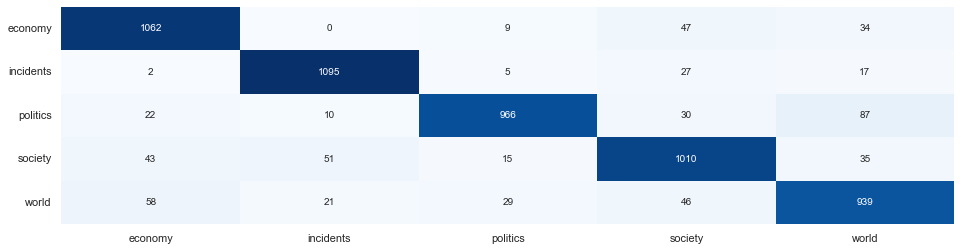

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

In [ ]:
%%prun
df['install_date'] = pd.to_datetime(df['install_date']).dt.date
df['install_date'] = df['install_date'].astype(str)